## Exploring data quality

In [1]:
import pandas as pd
import numpy as np
import os
import gc
import matplotlib.pyplot as plt

_FOLDER = "database/"
_FOLDER_2 = "figures/"
_FOLDER_3 = "results/"
SAVE_FIGURES = False

from functions.filtering import *
from functions.fitting import *
from functions.plotting import *

In [2]:
Y_LIMIT_1 = 0.8 # for group 1a
R2_LIMIT = 0.9 # for S-shape fitting
Y_LOWER_LIMIT  = 0.5 #for group 2a

### Original data

In [3]:
_FOLDER = "C:/Users/junny/GitRepos/DrugProfiles_2/database/"

drug_curves = pd.read_csv(_FOLDER+"normalised_dose_response_data.csv")

if "Unnamed: 0" in drug_curves:
    drug_curves.drop("Unnamed: 0", axis=1, inplace =True)

col_to_drop = ["per_slope_change_"+str(i) for i in range(8)]+\
            ["slope_" + str(i) for i in range(9)]    
drug_curves.drop(col_to_drop, axis=1, inplace=True)    
    
conc_columns= ["fd_num_"+str(i) for i in range(10)]
response_norm = ['norm_cells_'+str(i) for i in range(10)]
CCL_names = dict(zip(drug_curves["COSMIC_ID"], drug_curves["CELL_LINE_NAME"]))
df= pd.read_csv(_FOLDER+'Drug_Features.csv')
drug_names = dict(zip(df["Drug ID"].values, df["Drug Name"].values))
del df
drug_curves["drug_name"] = drug_curves["DRUG_ID"].map(drug_names)
drug_curves["CCL_name"] = drug_curves["COSMIC_ID"].map(CCL_names)
drug_curves.shape

(225384, 28)

## Group 1: Responses above 1

In [4]:
#available functions in a filtering script
print("Available functions in filtering module: \n")
for func in content_filtering().keys():
    print(func)

Available functions in filtering module: 

find_high_responses
cut_off_outliers
find_ascending_data
filtering_sigmoid_curves
auc_filtration
filter_good_response
select_group_limits
select_group_1
select_group_1a
select_group_1b
select_group_2
select_group_2a
select_group_2b


In [5]:
# group 1 - all responses above 1
gr_1 = select_group_1(drug_curves, response_norm)
gr_1.shape

(162059, 28)

In [6]:
gr_1a = select_group_1a(gr_1, response_norm, Y_LIMIT_1)
gr_1a.shape

(74115, 28)

In [7]:
%%time
fit_functions = ["sigmoid_4_param","logistic_4_param"]

gr_1b = select_group_1b(gr_1.loc[list(set(gr_1.index)-set(gr_1a.index))], 
                        fit_functions, conc_columns, response_norm, 
                        y_limit=Y_LIMIT_1, r2_limit=R2_LIMIT,
                       )
gr_1b.shape 


 sigmoid_4_param


100%|███████████████████████████████████████████████████████████████████████████| 87944/87944 [07:54<00:00, 185.25it/s]


<function sigmoid_4_param at 0x00000264F5328EA0>

 logistic_4_param


100%|███████████████████████████████████████████████████████████████████████████| 87944/87944 [06:19<00:00, 231.87it/s]


<function logistic_4_param at 0x00000264F5329080>
CPU times: total: 14min 17s
Wall time: 14min 14s


(41602, 32)

In [8]:
gr_1b.columns

Index(['CELL_LINE_NAME', 'COSMIC_ID', 'DRUG_ID', 'DRUGID_COSMICID',
       'FOLD_DILUTION', 'MAX_CONC', 'fd_num_0', 'fd_num_1', 'fd_num_2',
       'fd_num_3', 'fd_num_4', 'fd_num_5', 'fd_num_6', 'fd_num_7', 'fd_num_8',
       'fd_num_9', 'norm_cells_0', 'norm_cells_1', 'norm_cells_2',
       'norm_cells_3', 'norm_cells_4', 'norm_cells_5', 'norm_cells_6',
       'norm_cells_7', 'norm_cells_8', 'norm_cells_9', 'drug_name', 'CCL_name',
       'sigmoid_4_param_r2', 'sigmoid_4_param', 'logistic_4_param_r2',
       'logistic_4_param'],
      dtype='object')

In [9]:
gr_1c = gr_1.loc[list(set(gr_1.index)-set(gr_1a.index)-set(gr_1b.index))]
gr_1c.shape

(46342, 28)

In [10]:
assert gr_1.shape[0]==gr_1a.shape[0]+gr_1b.shape[0]+gr_1c.shape[0]

In [11]:
gr_2 = select_group_2(drug_curves, response_norm)
gr_2.shape

(63325, 28)

In [12]:
gr_2a = select_group_2a(drug_curves, response_norm, Y_LOWER_LIMIT)
gr_2a.shape

(26849, 29)

In [13]:
%%time
fit_functions = ["sigmoid_4_param","logistic_4_param"]

gr_2b = select_group_2b(gr_2.loc[list(set(gr_2.index)-set(gr_2a.index))],
                        fit_functions, conc_columns, response_norm,
                        y_lower_limit =Y_LOWER_LIMIT, r2_limit= R2_LIMIT
                       )
gr_2b.shape 


 sigmoid_4_param


100%|███████████████████████████████████████████████████████████████████████████| 36476/36476 [03:29<00:00, 174.07it/s]


<function sigmoid_4_param at 0x00000264F5328EA0>

 logistic_4_param


100%|███████████████████████████████████████████████████████████████████████████| 36476/36476 [02:39<00:00, 229.08it/s]

<function logistic_4_param at 0x00000264F5329080>
CPU times: total: 6min 7s
Wall time: 6min 8s


(24026, 32)

In [14]:
gr_2c = gr_2.loc[list(set(gr_2.index)-set(gr_2a.index)-set(gr_2b.index))]
gr_2c.shape

(12450, 28)

In [15]:
assert gr_2.shape[0]==gr_2a.shape[0]+gr_2b.shape[0]+gr_2c.shape[0]

### Save figures for the paper

In [16]:
def OneFigNoFitting(df, drug_id, ccl_name, 
                    x_columns, y_columns, size=8,dpi=300,
                    upper_limit=None, lower_limit=None, save_fig_name=None):
    
    ind = df[(df["DRUG_ID"]==drug_id)&(df["CELL_LINE_NAME"]==ccl_name)].index
    drug_name = df.loc[ind, "drug_name"].values[0]
    
    print(f"Drug: {drug_name} ({drug_id}) / CCL: {ccl_name}")# % drug_name +str(drug_id) +" / CCL: "+ str(ccl_name))
    x = df.loc[ind, x_columns]
    y = df.loc[ind, y_columns].values[0] #possible problems are here
    
    plt.figure(figsize=(size, size))
    if max(y)>1:
        max_y= max(y)+0.1
    else:
        max_y = 1.1
    plt.ylim([0, max_y])
    plt.scatter(x,y)
    
    plt.xlabel("Scaled dosage")
    plt.ylabel("Normalised response")
    if upper_limit:
        plt.axhline(upper_limit,color='red',ls='--')
    if lower_limit:
        plt.axhline(lower_limit, color='black',ls='--')

    plt.tick_params(labelsize=14)
    plt.xlabel("Scaled dosage", fontsize=14)
    plt.ylabel("Normalised Response", fontsize=14)
    if save_fig_name:
        
        plt.savefig(save_fig_name, bbox_inches='tight', dpi=dpi)
        plt.show();
    else:
        plt.show();
        

Drug: Avagacestat (205) / CCL: ES6


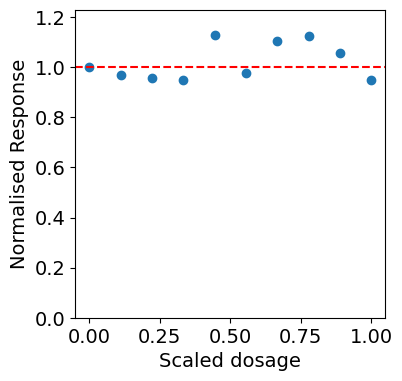

In [17]:
# group_1a
group = "1a"
drug_id = 205
ccl_name = "ES6"
one_fig_no_fitting(gr_1, drug_id=drug_id, ccl_name=ccl_name, size=4, dpi=500,
                x_columns = conc_columns, y_columns = response_norm, 
                upper_limit=1, lower_limit=None, 
                save_fig_name=f"figures/gr_{group}_{drug_id}_{ccl_name}.png"
               )

Drug: UNC0638 (245) / CCL: HDQ-P1


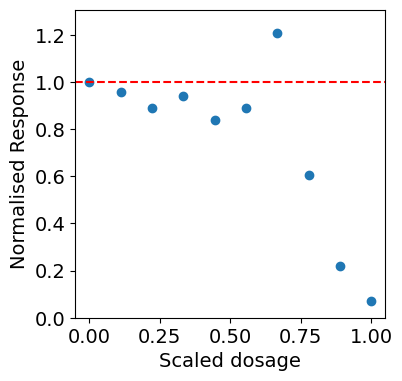

In [18]:
# group_1b
group = "1b"
drug_id = 245
ccl_name = "HDQ-P1"
OneFigNoFitting(gr_1b, drug_id=drug_id, ccl_name=ccl_name, size=4, dpi=500,
                x_columns = conc_columns, y_columns = response_norm, 
                upper_limit=1, lower_limit=None, 
                save_fig_name=f"figures/gr_{group}_{drug_id}_{ccl_name}.png"
               )

Drug: WH-4-023 (56) / CCL: RKO


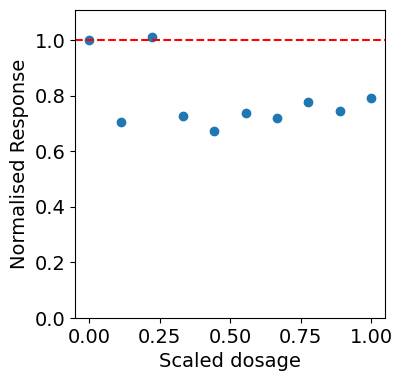

In [19]:
# group_1c
group = "1c"
drug_id = 56
ccl_name = "RKO"
OneFigNoFitting(gr_1c, drug_id=drug_id, ccl_name=ccl_name, size=4, dpi=500,
                x_columns = conc_columns, y_columns = response_norm, 
                upper_limit=1, lower_limit=None, 
                save_fig_name=f"figures/gr_{group}_{drug_id}_{ccl_name}.png"
               )

Drug: ZSTK474 (223) / CCL: HDQ-P1


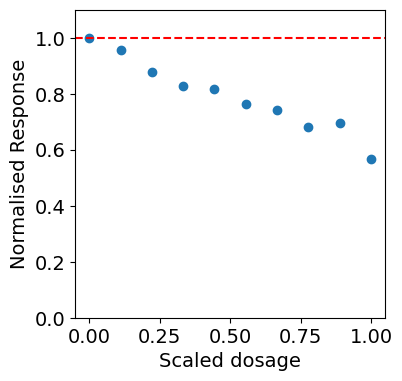

In [20]:
# group_2a
group = "2a"
drug_id = 223
ccl_name = "HDQ-P1"
OneFigNoFitting(gr_2a, drug_id=drug_id, ccl_name=ccl_name, size=4, dpi=500,
                x_columns = conc_columns, y_columns = response_norm, 
                upper_limit=1, lower_limit=None, 
                save_fig_name=f"figures/gr_{group}_{drug_id}_{ccl_name}.png"
               )

Drug: WZ3105 (252) / CCL: SK-MEL-30


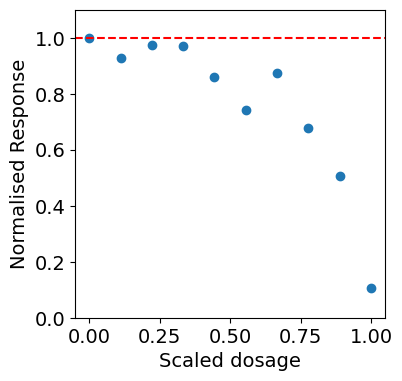

In [21]:
# group_2b
group = "2b"
drug_id = 252
ccl_name = "SK-MEL-30"
OneFigNoFitting(gr_2b, drug_id=drug_id, ccl_name=ccl_name, size=4, dpi=500,
                x_columns = conc_columns, y_columns = response_norm, 
                upper_limit=1, lower_limit=None, 
                save_fig_name=f"figures/gr_{group}_{drug_id}_{ccl_name}.png"
               )

In [22]:
gr_2c.sample(5)

,CELL_LINE_NAME,COSMIC_ID,DRUG_ID,DRUGID_COSMICID,FOLD_DILUTION,MAX_CONC,fd_num_0,fd_num_1,fd_num_2,fd_num_3,...,norm_cells_2,norm_cells_3,norm_cells_4,norm_cells_5,norm_cells_6,norm_cells_7,norm_cells_8,norm_cells_9,drug_name,CCL_name
223716,JHU-019,1298153,1378,1378_1298153,4,50.0,0,0.200000,0.400000,0.600000,...,0.571392,0.559296,0.449459,0.300643,NaN,NaN,NaN,NaN,Bleomycin (50 uM),JHU-019
154062,HL-60,905938,1066,1066_905938,2,5.0,0,0.111111,0.222222,0.333333,...,0.981982,0.912333,0.519447,0.818997,0.766533,0.495399,0.296832,0.331665,AZD6482,HL-60
135342,MC-CAR,683665,291,291_683665,2,20.0,0,0.111111,0.222222,0.333333,...,0.979063,0.884710,0.932997,0.920749,0.853823,0.856009,0.862335,0.000666,KIN001-266,MC-CAR
210712,AGS,906790,1378,1378_906790,4,50.0,0,0.200000,0.400000,0.600000,...,0.430173,0.350683,0.268784,0.152982,NaN,NaN,NaN,NaN,Bleomycin (50 uM),AGS
223977,697,906800,1527,1527_906800,4,4.0,0,0.200000,0.400000,0.600000,...,0.718891,0.609656,0.454785,0.317263,NaN,NaN,NaN,NaN,Pictilisib,697


Drug: (5Z)-7-Oxozeaenol (1242) / CCL: CAL-29


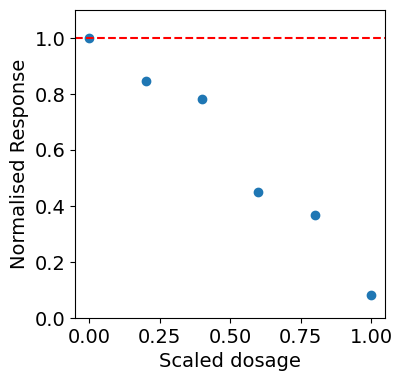

In [23]:
# group_2c
group = "2c"
drug_id = 1242
ccl_name = "CAL-29"
OneFigNoFitting(gr_2c, drug_id=drug_id, ccl_name=ccl_name, size=4, dpi=500,
                x_columns = conc_columns, y_columns = response_norm, 
                upper_limit=1, lower_limit=None, 
                save_fig_name=f"figures/gr_{group}_{drug_id}_{ccl_name}.png"
               )

In [24]:
import all_functions

## Ambigous data: Are some points wrong?

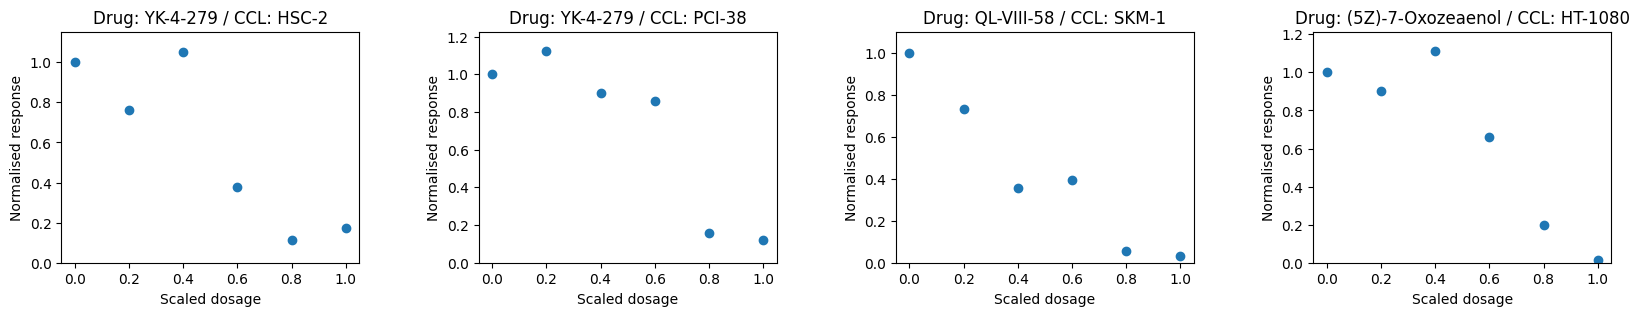

In [25]:
specific_samples = [("YK-4-279", "HSC-2"),
                    ("YK-4-279", "PCI-38"),
                   ("QL-VIII-58", "SKM-1"),
                    ("(5Z)-7-Oxozeaenol", "HT-1080")
                   ]
show_specific(drug_curves, specific_samples, conc_columns, response_norm)

# Part 3: Explore  curves with normalised responses above 1.0

In [26]:
%%time
# Number of responses > 1
drug_curves["high_responses"] = drug_curves[response_norm].apply(lambda row: sum(row>1), axis=1)
drug_curves[["high_responses"]+ response_norm]

CPU times: total: 18.2 s
Wall time: 19 s


,high_responses,norm_cells_0,norm_cells_1,norm_cells_2,norm_cells_3,norm_cells_4,norm_cells_5,norm_cells_6,norm_cells_7,norm_cells_8,norm_cells_9
0,7,1,1.039343,0.998020,1.005715,1.055723,1.050223,1.035580,1.063019,0.925303,1.083254
1,6,1,0.969418,0.987582,1.052708,1.072808,1.048205,1.009425,1.026961,1.036639,0.752796
2,1,1,0.956127,0.887779,0.941691,0.839059,0.890866,1.206129,0.605122,0.219697,0.072674
3,4,1,1.087946,0.980767,1.118407,1.234735,1.162228,0.948777,0.888637,0.835206,0.720549
4,6,1,1.035268,1.040170,0.972972,1.029729,0.981819,1.045795,1.310285,1.222109,0.998711
...,...,...,...,...,...,...,...,...,...,...,...
225379,3,1,0.970321,0.864856,1.326808,1.100719,1.116878,NaN,NaN,NaN,NaN
225380,3,1,0.329169,0.284518,1.088894,1.090624,1.104720,NaN,NaN,NaN,NaN
225381,3,1,0.914628,0.840454,1.116674,1.096159,1.107695,NaN,NaN,NaN,NaN
225382,2,1,0.884687,1.000038,1.051918,0.790004,0.138294,NaN,NaN,NaN,NaN


In [27]:
bad_data = drug_curves[drug_curves["high_responses"]>1]
print("Original data:", drug_curves.shape)
print("Ambiguos data:", bad_data.shape)

Original data: (225384, 29)
Ambiguos data: (127590, 29)


### Note: Half of the data can be regarded as ambiguous!!!

In [28]:
bad_data["high_responses"].value_counts()

2    28485
3    24334
4    20015
5    17201
6    12366
7    10712
8     8487
9     5990
Name: high_responses, dtype: int64

## Bad data by CCL

## Check whether bad data are actually bad

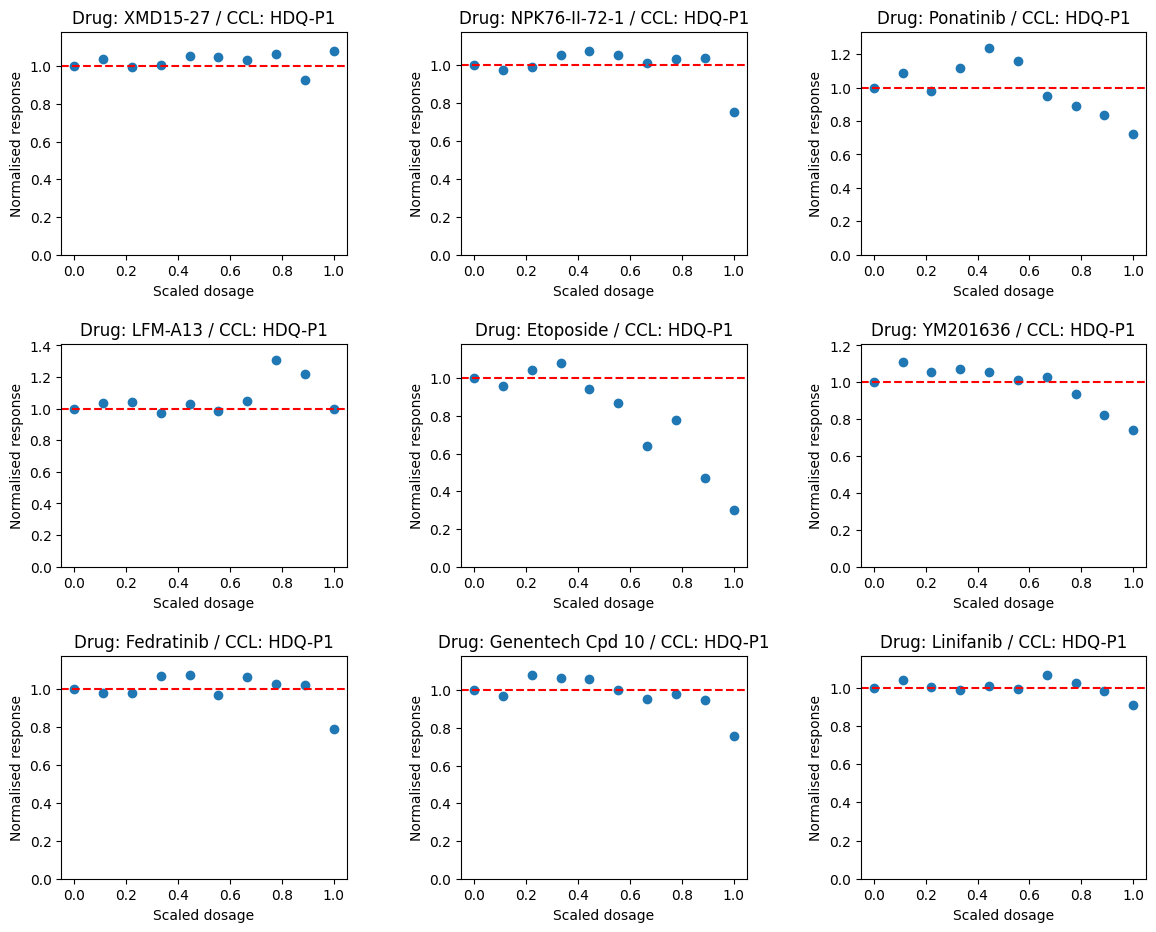

In [29]:
df = bad_data
show_response_curves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9],
                  drug_dict = drug_names, CCL_dict = CCL_names, upper_limit=1)

## Samples with 2 bad responses

Number of samples with 2 bad responses: 28485


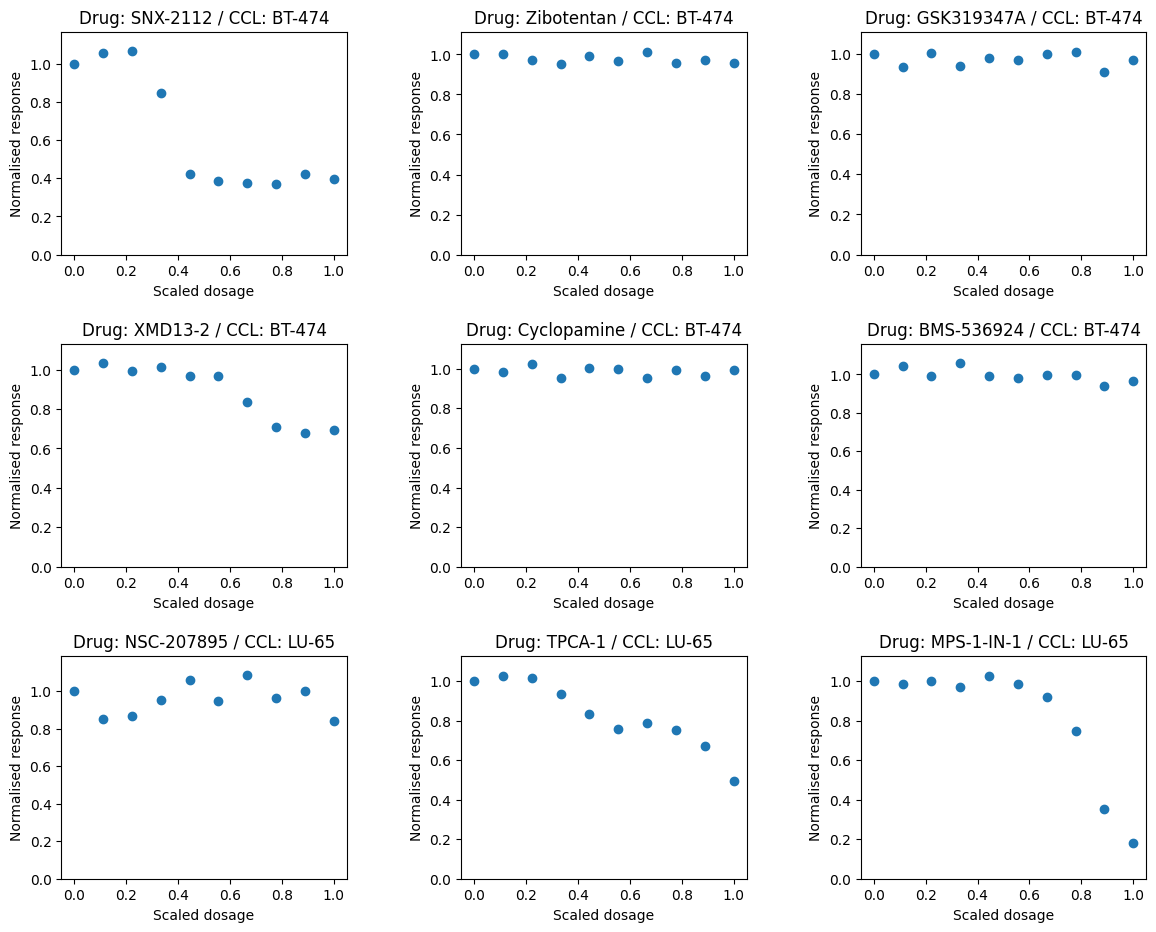

In [30]:
N = 2
df = bad_data[bad_data["high_responses"]==N]
print("Number of samples with %d bad responses: %d" % (N, df.shape[0]))

show_response_curves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[20:29],
                  drug_dict = drug_names, CCL_dict = CCL_names)

### Among samples with only 2 norm_responses >1 some data are not so bad

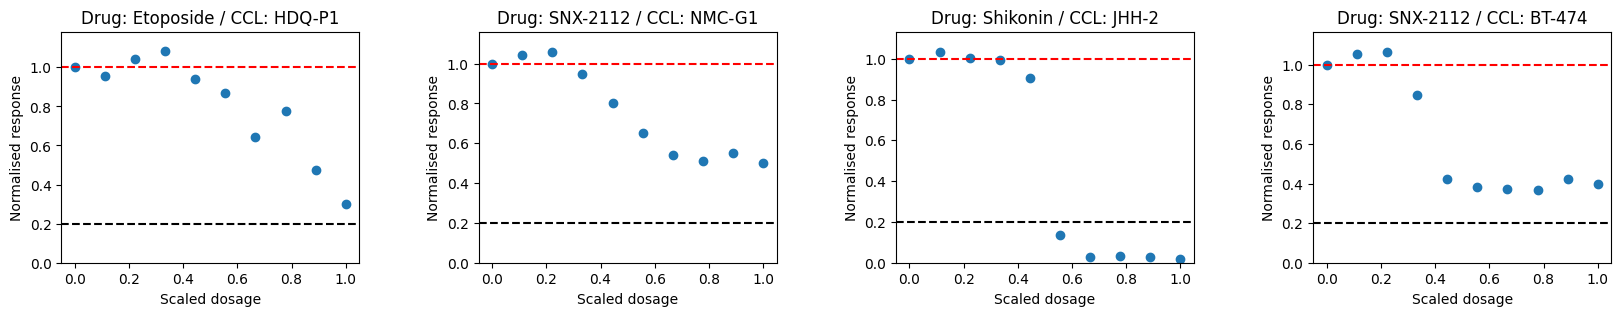

In [31]:
specific_samples = [("Etoposide", "HDQ-P1"),
                    ("SNX-2112", "NMC-G1"),
                    ("Shikonin", "JHH-2"),
                    ("SNX-2112", "BT-474")
                   ]
show_specific(bad_data, specific_samples, conc_columns, response_norm, upper_limit=1, lower_limit=0.2)

Number of samples with 2 bad responses, but with 2 last responses below 0.2: 2728


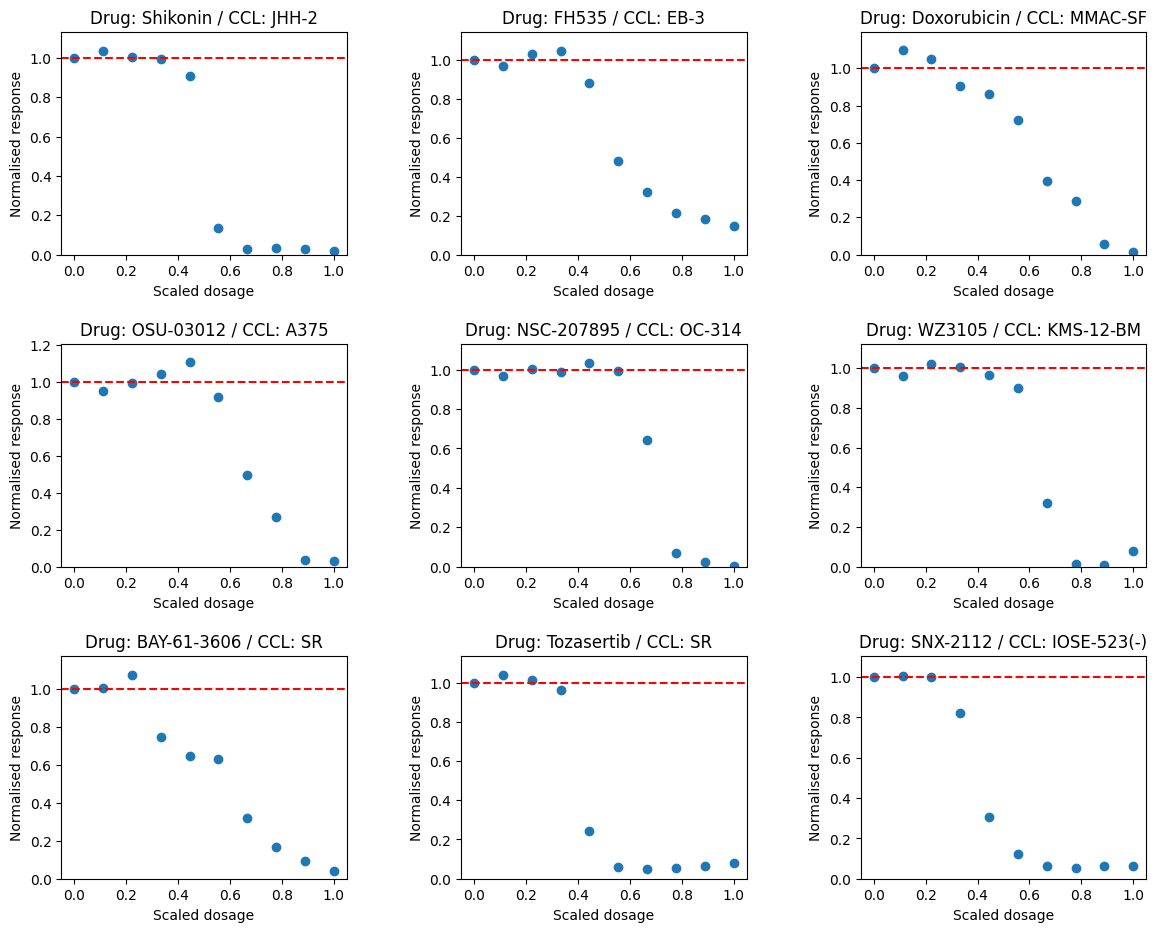

In [32]:
N = 2
df = bad_data[(bad_data["high_responses"]==N) & (bad_data["norm_cells_9"]<0.2) & (bad_data["norm_cells_8"]<0.2)]
print("Number of samples with %d bad responses, but with 2 last responses below 0.2: %d" % (N, df.shape[0]))

show_response_curves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9],
                  drug_dict = drug_names, CCL_dict = CCL_names, upper_limit=1)

### Conclusion - we can't delete just samples which with 2 responses>1.0
### The question: What is the accuracy of measuring responses? <br>Can we treat samples with responses up to 1.01 as valid ones?

## Samples with 3 bad responses

Number of samples with 3 bad responses: 24334


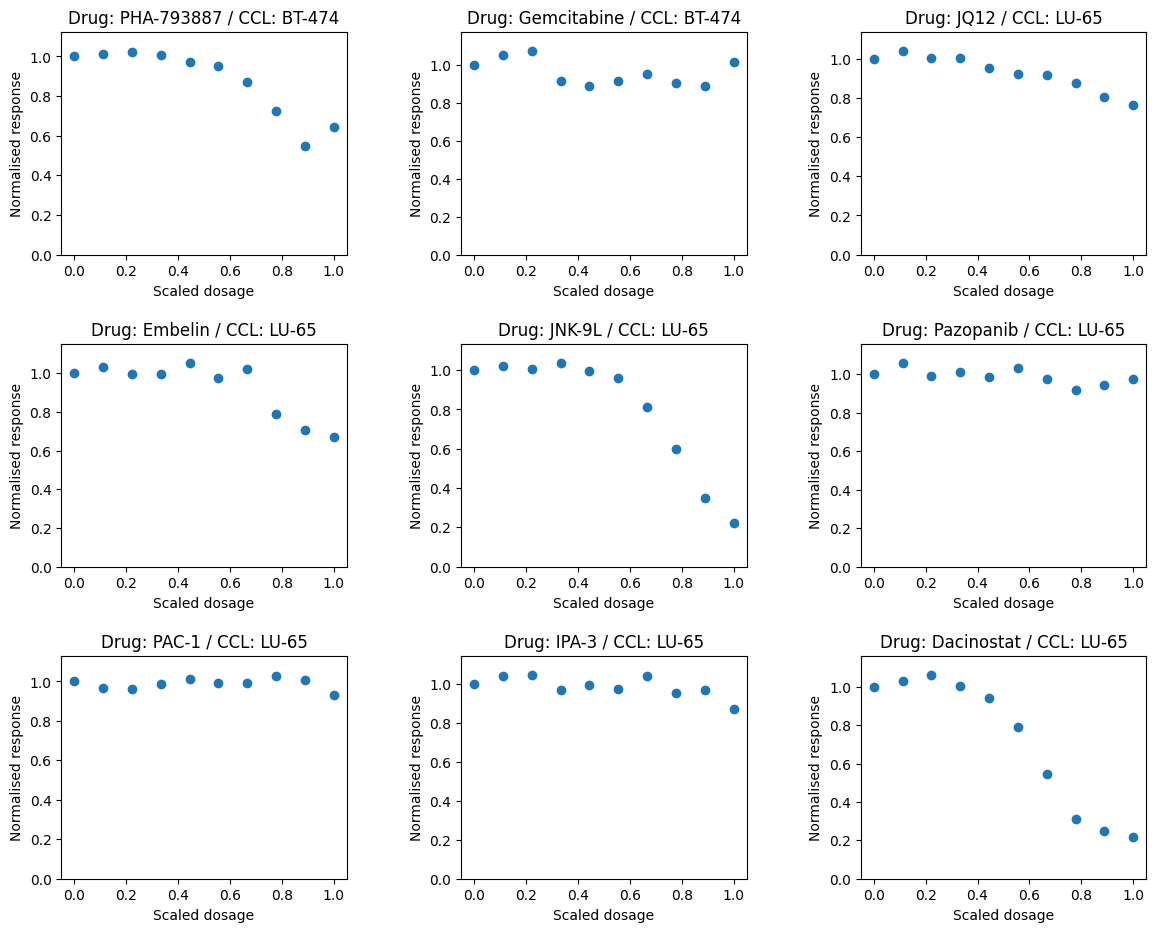

In [33]:
N = 3
df = bad_data[bad_data["high_responses"]==N]
print("Number of samples with %d bad responses: %d" % (N, df.shape[0]))

show_response_curves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[30:39],
                  drug_dict = drug_names, CCL_dict = CCL_names)

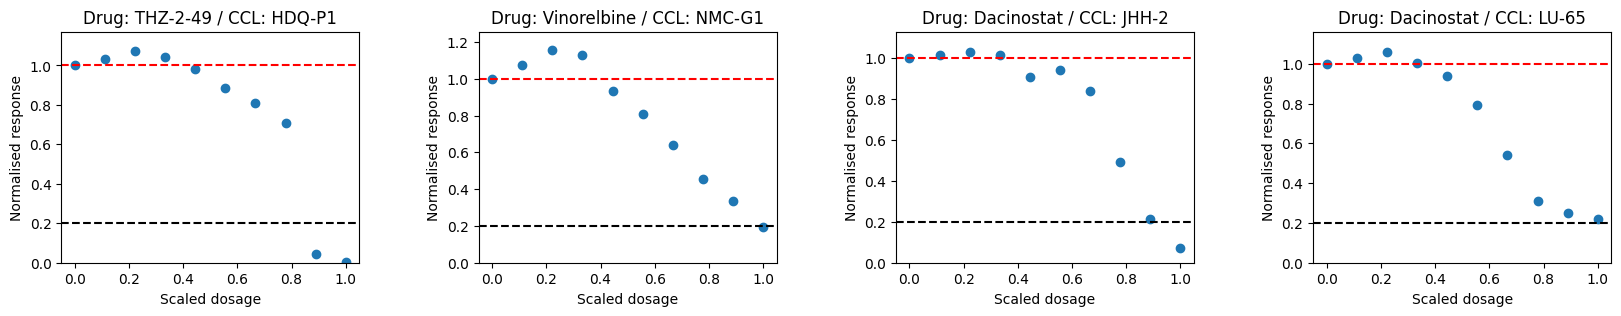

In [34]:
specific_samples = [("THZ-2-49", "HDQ-P1"),
                    ("Vinorelbine", "NMC-G1"),
                    ("Dacinostat", "JHH-2"),
                    ("Dacinostat", "LU-65")
                   ]
show_specific(bad_data, specific_samples, conc_columns, response_norm, upper_limit=1, lower_limit=0.2)

Number of samples with 3 bad responses, but with 2 last responses below 0.2: 1780


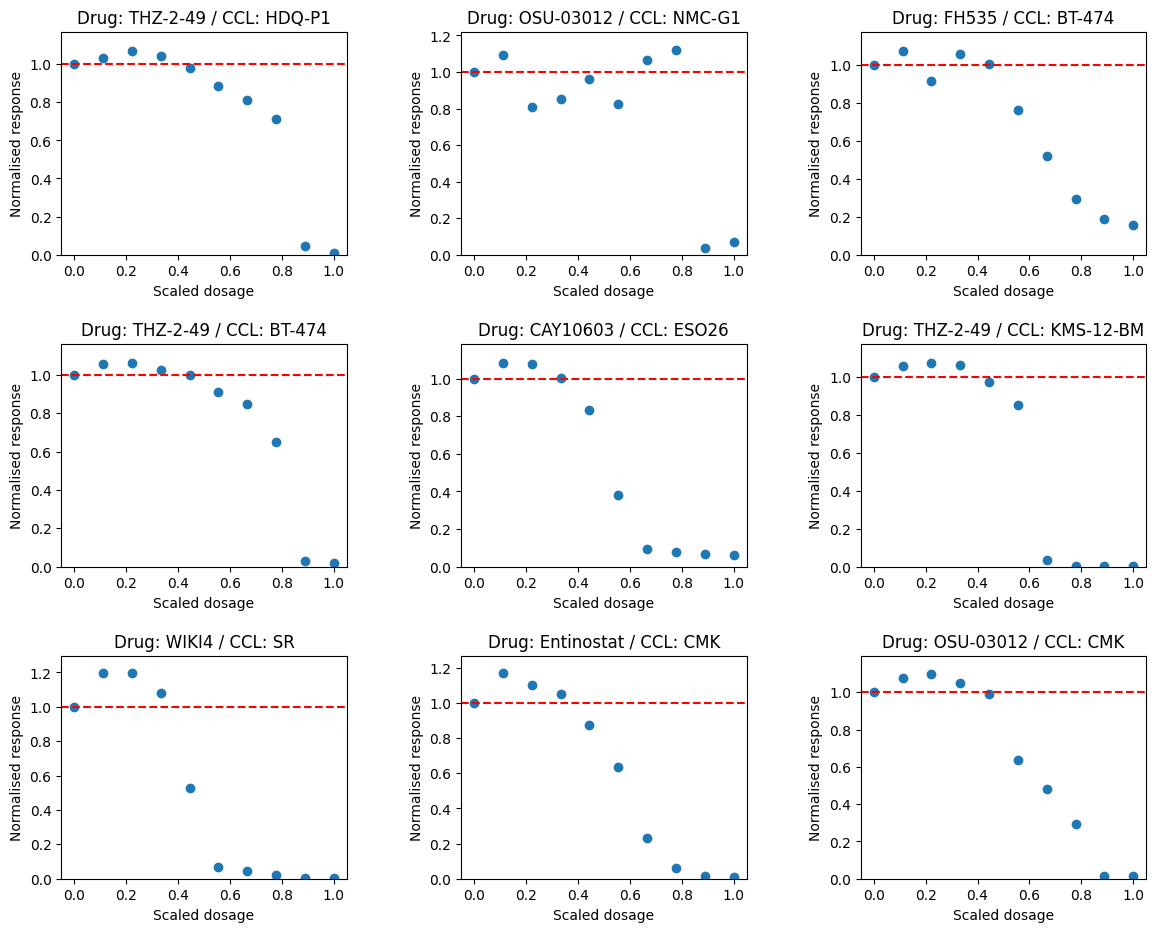

In [35]:
N = 3
df = bad_data[(bad_data["high_responses"]==N) & (bad_data["norm_cells_9"]<0.2) & (bad_data["norm_cells_8"]<0.2)]
print("Number of samples with %d bad responses, but with 2 last responses below 0.2: %d" % (N, df.shape[0]))

show_response_curves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9],
                  drug_dict = drug_names, CCL_dict = CCL_names, upper_limit=1)

## Samples with 4 bad responses 

Number of samples with 4 bad responses: 20015


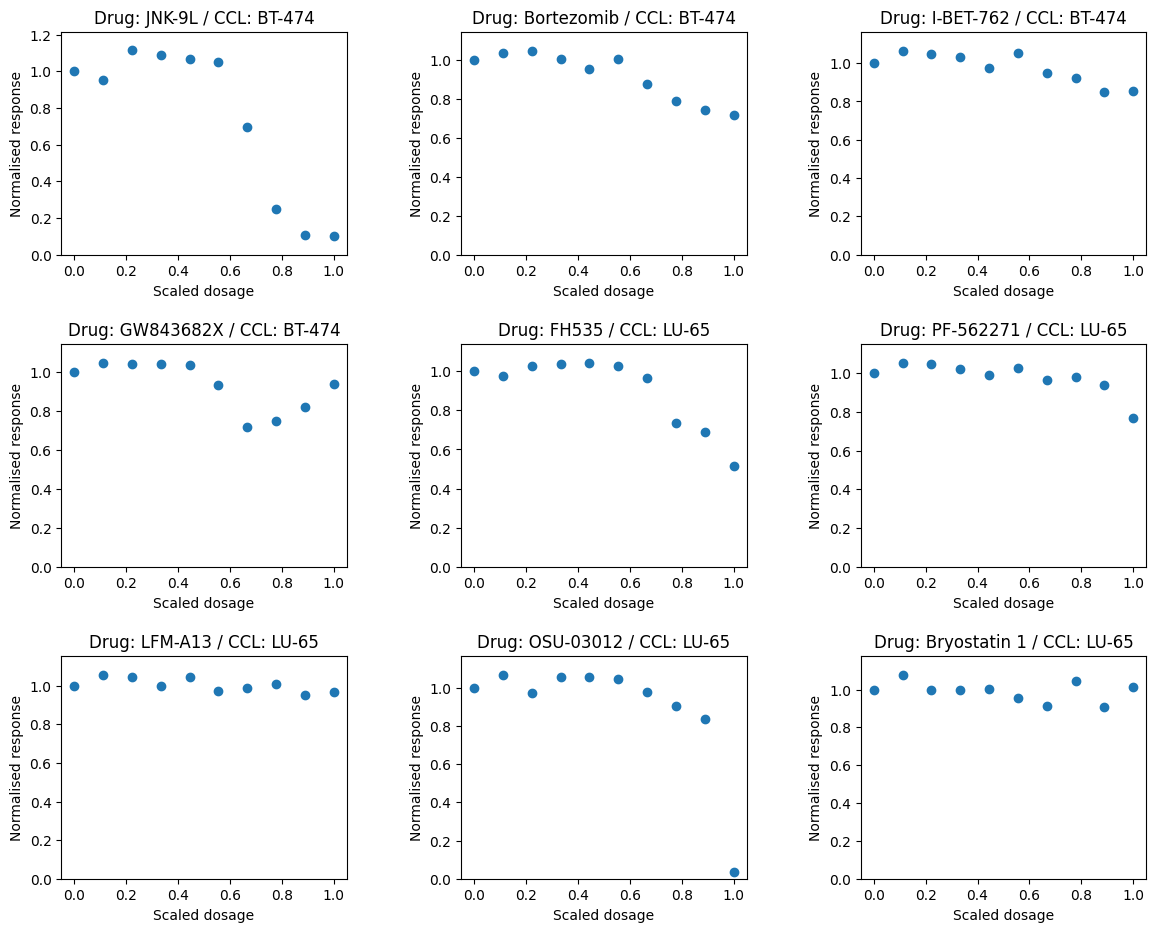

In [36]:
N = 4
df = bad_data[bad_data["high_responses"]==N]
print("Number of samples with %d bad responses: %d" % (N, df.shape[0]))

show_response_curves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[20:29],
                  drug_dict = drug_names, CCL_dict = CCL_names)

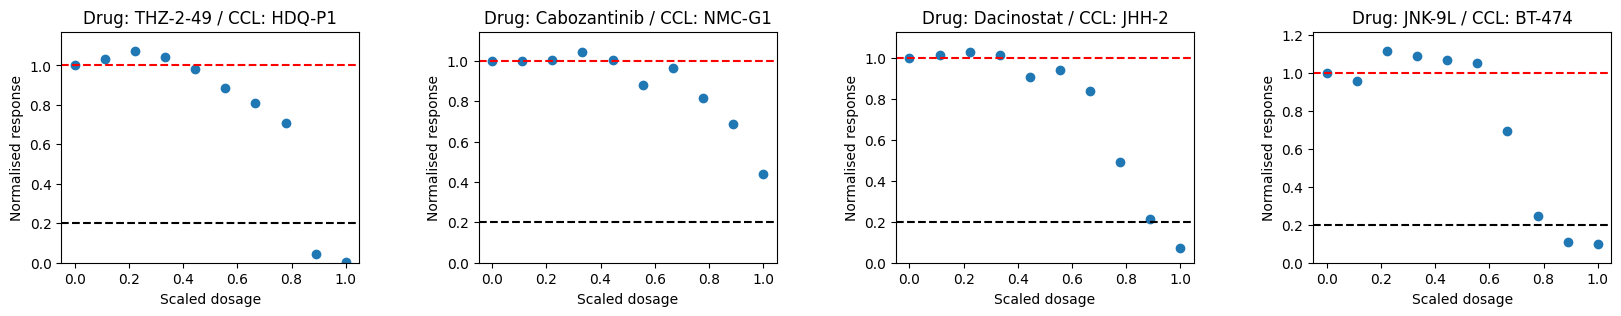

In [37]:
specific_samples = [("THZ-2-49", "HDQ-P1"),
                    ("Cabozantinib", "NMC-G1"),
                    ("Dacinostat", "JHH-2"),
                    ("JNK-9L", "BT-474")
                   ]
show_specific(bad_data, specific_samples, conc_columns, response_norm, upper_limit=1, lower_limit=0.2)

Number of samples with 4 bad responses, but with 2 last responses below 0.2: 879


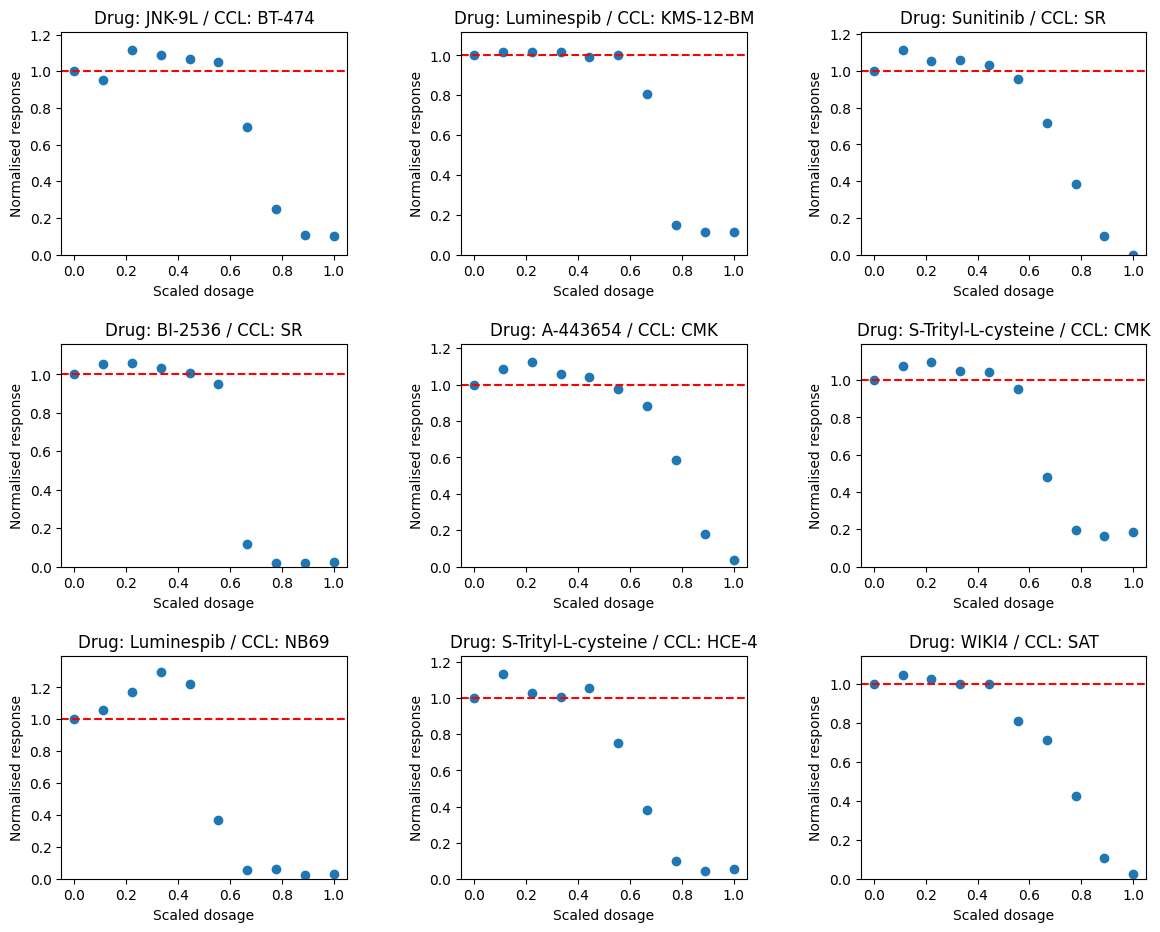

In [38]:
N = 4
df = bad_data[(bad_data["high_responses"]==N) & (bad_data["norm_cells_9"]<0.2) & (bad_data["norm_cells_8"]<0.2)]
print("Number of samples with %d bad responses, but with 2 last responses below 0.2: %d" % (N, df.shape[0]))

show_response_curves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9],
                  drug_dict = drug_names, CCL_dict = CCL_names, upper_limit=1)

## Samples with 5+ bad responses

Number of samples with more than 5 bad responses: 54756


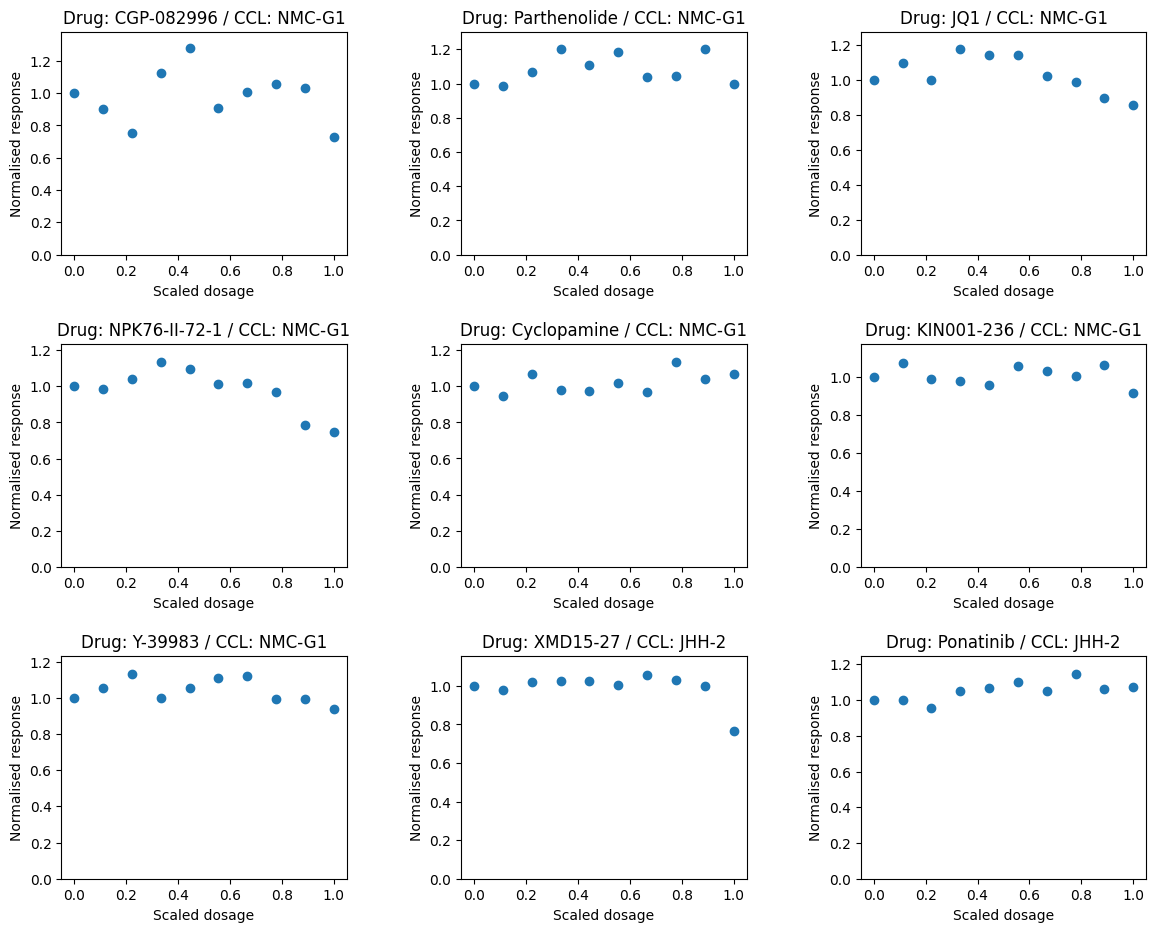

In [39]:
N = 5
df = bad_data[bad_data["high_responses"]>=N]
print("Number of samples with more than %d bad responses: %d" % (N, df.shape[0]))

show_response_curves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[20:29],
                  drug_dict = drug_names, CCL_dict = CCL_names)

Number of samples with 5 bad responses, but with 2 last responses below 0.2: 441


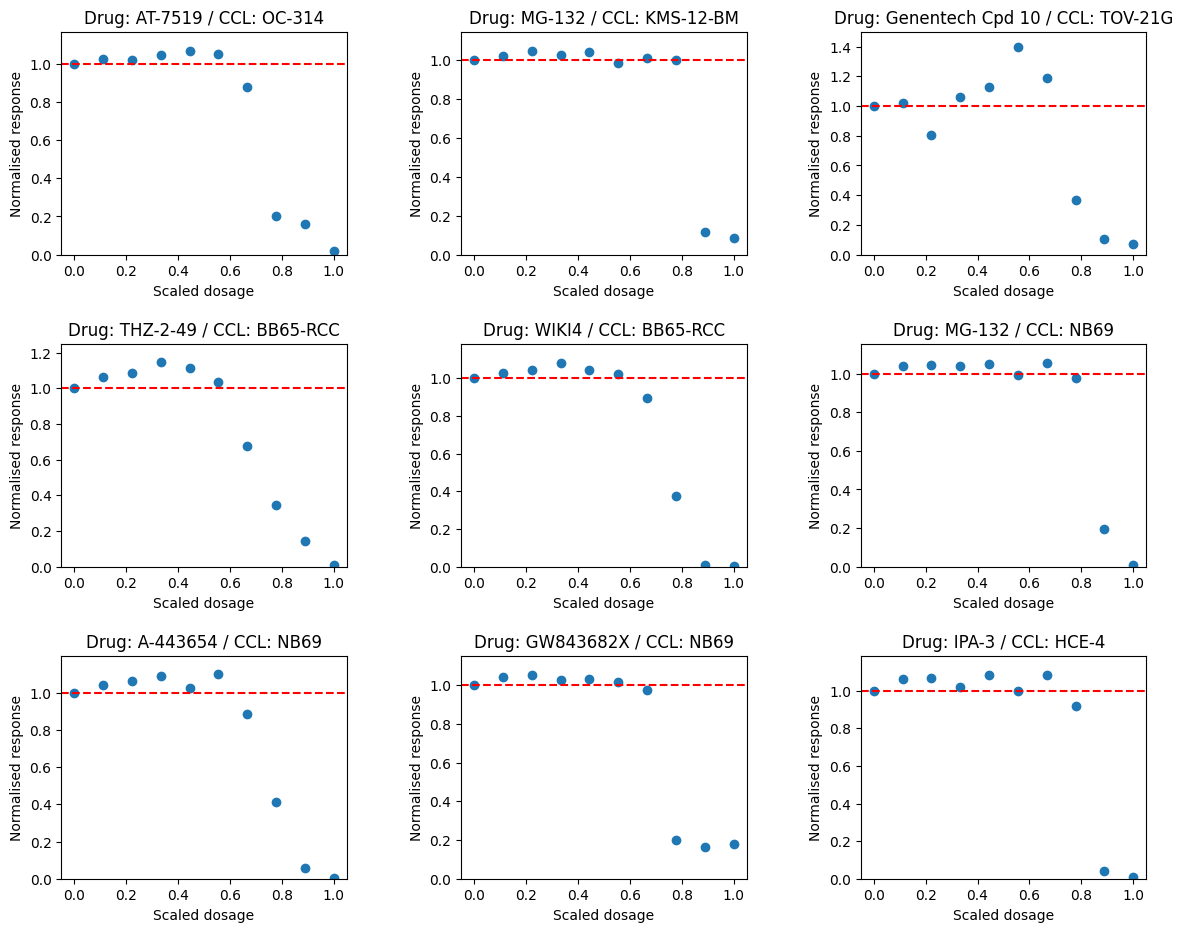

In [40]:
N = 5
df = bad_data[(bad_data["high_responses"]==N) & (bad_data["norm_cells_9"]<0.2) & (bad_data["norm_cells_8"]<0.2)]
print("Number of samples with %d bad responses, but with 2 last responses below 0.2: %d" % (N, df.shape[0]))

show_response_curves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9],
                  drug_dict = drug_names, CCL_dict = CCL_names, upper_limit=1)

Number of samples with 6 bad responses, but with 2 last responses below 0.2: 135


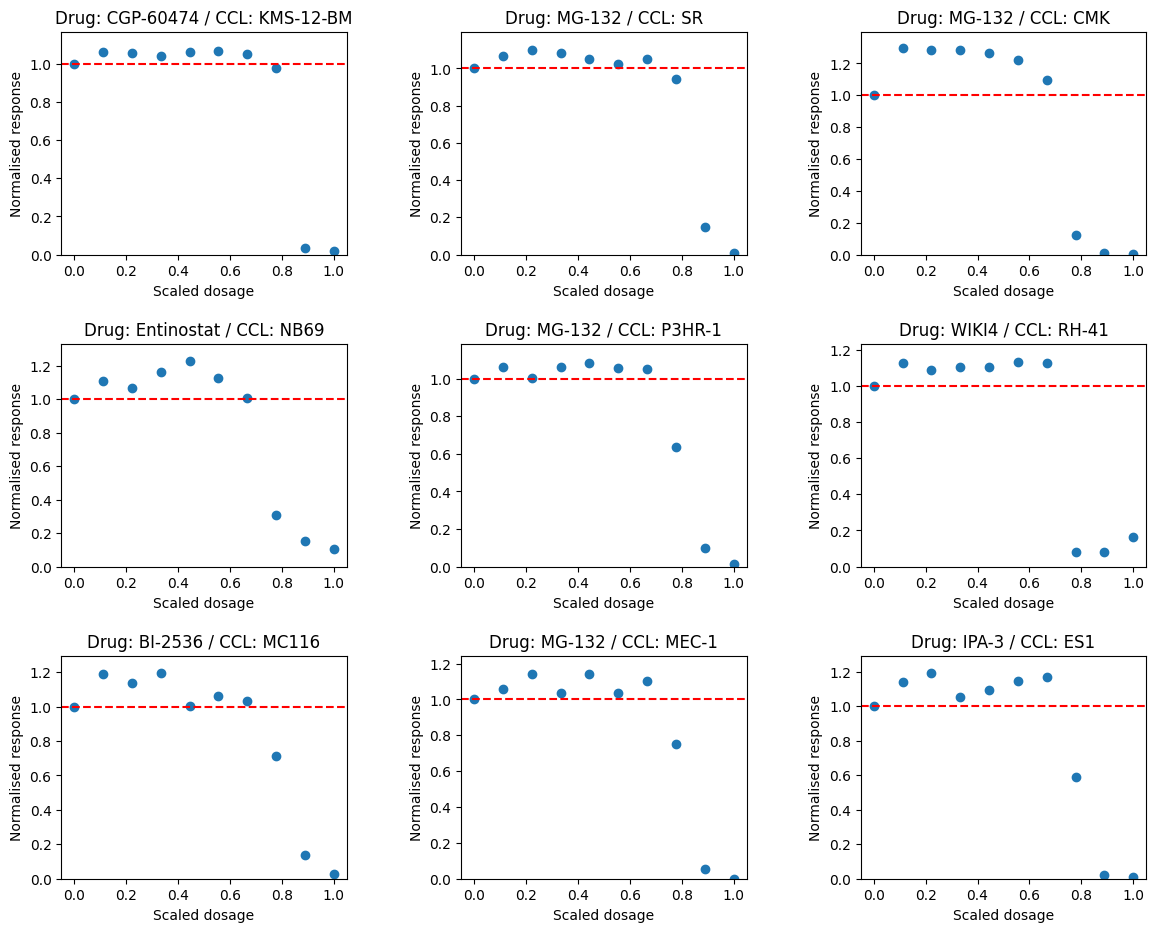

In [41]:
N = 6
df = bad_data[(bad_data["high_responses"]==N) & (bad_data["norm_cells_9"]<0.2) & (bad_data["norm_cells_8"]<0.2)]
print("Number of samples with %d bad responses, but with 2 last responses below 0.2: %d" % (N, df.shape[0]))

show_response_curves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9],
                  drug_dict = drug_names, CCL_dict = CCL_names, upper_limit=1)

Number of samples with 7 bad responses, but with 2 last responses below 0.2: 18


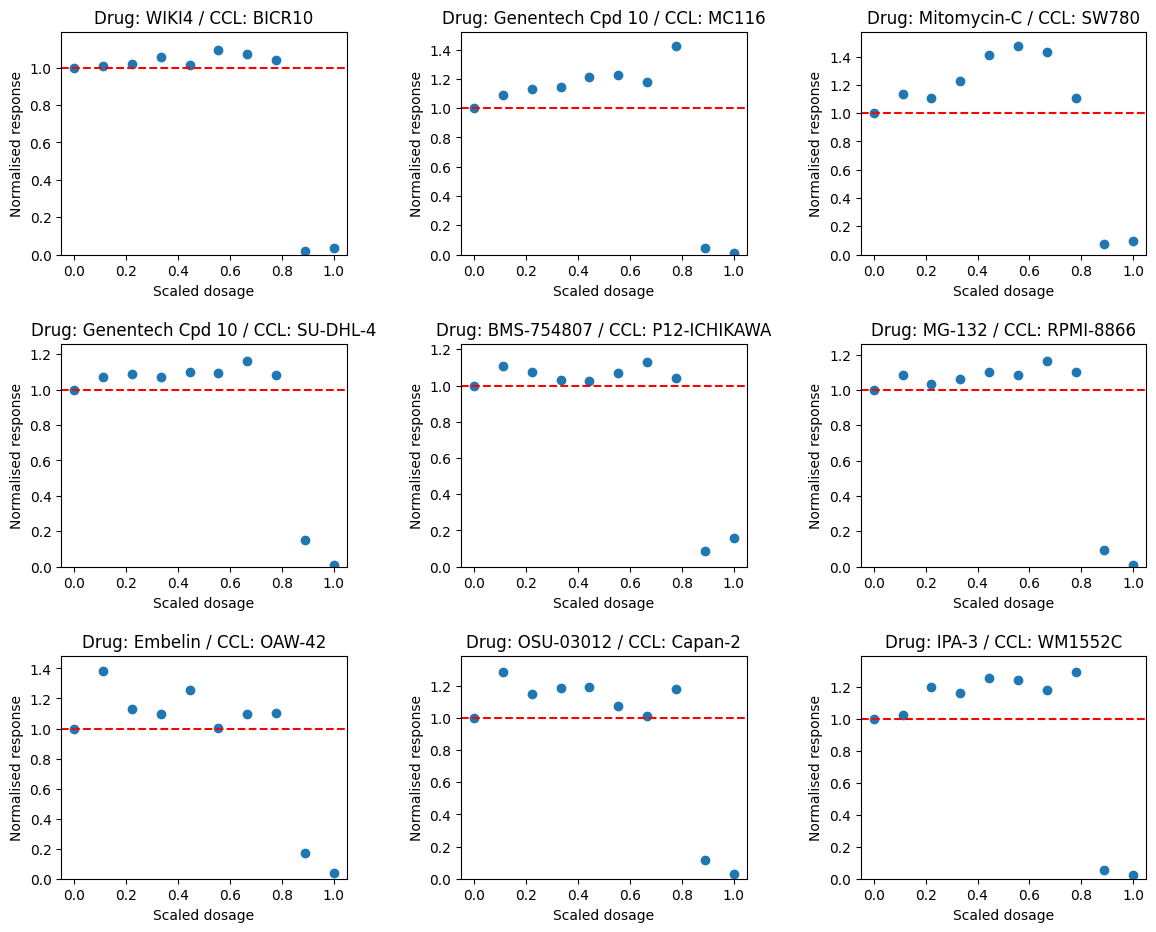

In [42]:
N = 7
df = bad_data[(bad_data["high_responses"]==N) & (bad_data["norm_cells_9"]<0.2) & (bad_data["norm_cells_8"]<0.2)]
print("Number of samples with %d bad responses, but with 2 last responses below 0.2: %d" % (N, df.shape[0]))

show_response_curves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9],
                  drug_dict = drug_names, CCL_dict = CCL_names, upper_limit=1)

In [43]:
N = 8
df = bad_data[(bad_data["high_responses"]==N) & (bad_data["norm_cells_9"]<0.2) & (bad_data["norm_cells_8"]<0.2)]
print("Number of samples with %d bad responses, but with 2 last responses below 0.2: %d" % (N, df.shape[0]))

show_response_curves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9],
                  drug_dict = drug_names, CCL_dict = CCL_names, upper_limit=1)

Number of samples with 8 bad responses, but with 2 last responses below 0.2: 0


<Figure size 1400x1100 with 0 Axes>

In [44]:
N = 9
df = bad_data[(bad_data["high_responses"]==N) & (bad_data["norm_cells_9"]<0.2) & (bad_data["norm_cells_8"]<0.2)]
print("Number of samples with %d bad responses, but with 2 last responses below 0.2: %d" % (N, df.shape[0]))

show_response_curves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9],
                  drug_dict = drug_names, CCL_dict = CCL_names, upper_limit=1)

Number of samples with 9 bad responses, but with 2 last responses below 0.2: 0


<Figure size 1400x1100 with 0 Axes>

### Conclusion from Part 3: Curves with up to 7 suspiciously high normalised responses look pretty reasonable

## Part 4: Explore curves with normalised response above 1 but low final response

In [45]:
%%time
drug_curves["low_response_02"] = drug_curves[response_norm].apply(lambda row: sum(row<=0.2), axis=1)
drug_curves["low_response_04"] = drug_curves[response_norm].apply(lambda row: sum(row<=0.4), axis=1)

CPU times: total: 51 s
Wall time: 51.7 s


In [46]:
not_bad_02 = drug_curves[(drug_curves["high_responses"]>1) & (drug_curves["low_response_02"])]
not_bad_04 = drug_curves[(drug_curves["high_responses"]>1) & (drug_curves["low_response_04"])]
print("Number of all suspicious samples:", bad_data.shape[0])
print("\nNumber of potentionally good samples among all bad data:")
print("With responses below 0.2:", not_bad_02.shape[0])
print("With responses below 0.4:", not_bad_04.shape[0])

Number of all suspicious samples: 127590

Number of potentionally good samples among all bad data:
With responses below 0.2: 9892
With responses below 0.4: 16438


In [47]:
not_bad_02["low_response_02"].value_counts()

1    7742
3    1755
5     387
7       8
Name: low_response_02, dtype: int64

In [48]:
not_bad_04["low_response_04"].value_counts()

1    12144
3     3301
5      974
7       19
Name: low_response_04, dtype: int64

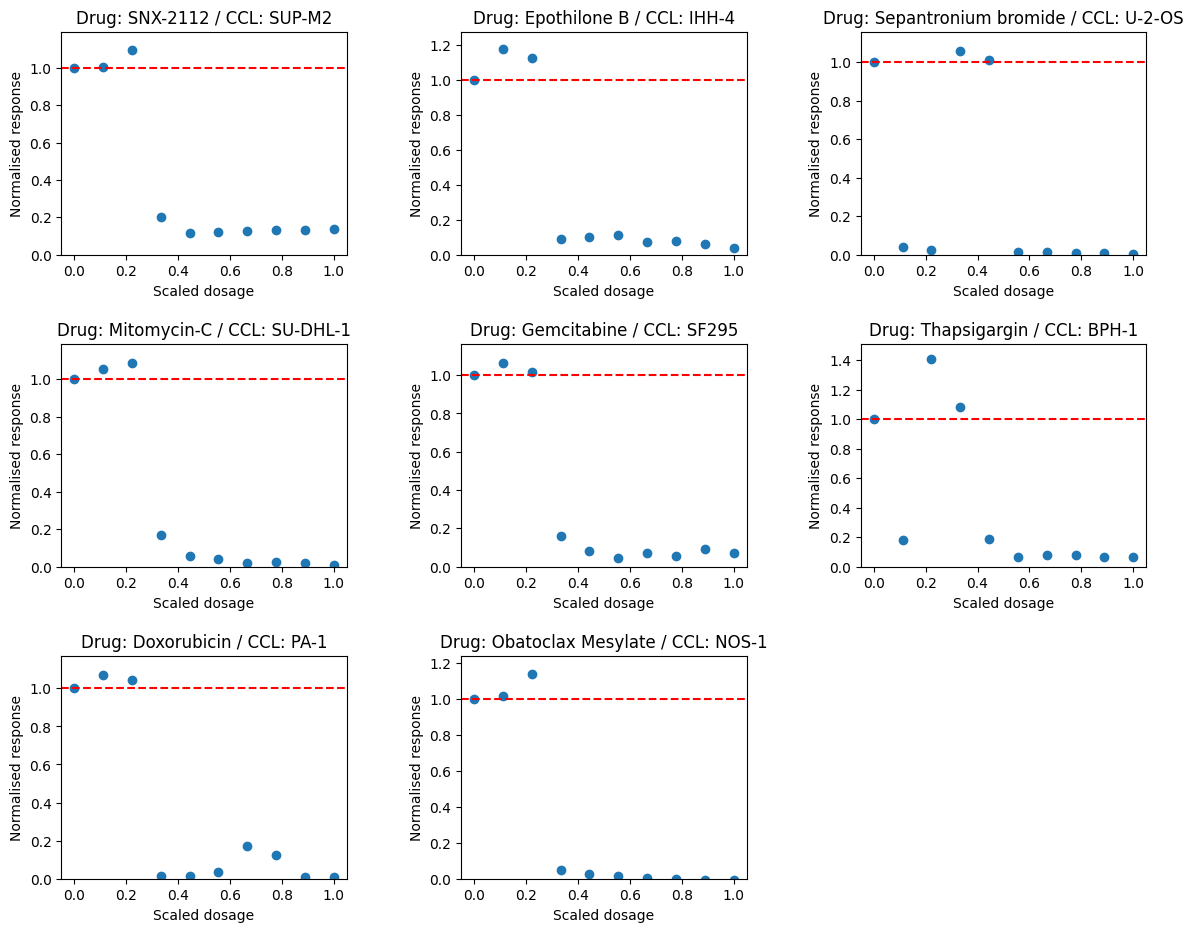

In [49]:
df = not_bad_02[not_bad_02["low_response_02"]==7]

show_response_curves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9],
                  drug_dict = drug_names, CCL_dict = CCL_names, upper_limit=1)

# Part 5: Repeat with an additional constrain 
## Among all "middle" datapoints a subsequent point should not be higher than antecedent by some limit

In [50]:
not_bad_02_2 = cut_off_outliers(drug_curves, middle_points_limit=-0.2, response_columns = response_norm)

print("Before filtration: %d, After filtration: %d" % (not_bad_04.shape[0], not_bad_02_2.shape[0]))
not_bad_02_2["low_response_02"].value_counts()

Before filtration: 16438, After filtration: 190245


0    151335
1     16124
2      7155
3      5384
4      4025
5      2654
6      1551
7       857
9       678
8       482
Name: low_response_02, dtype: int64

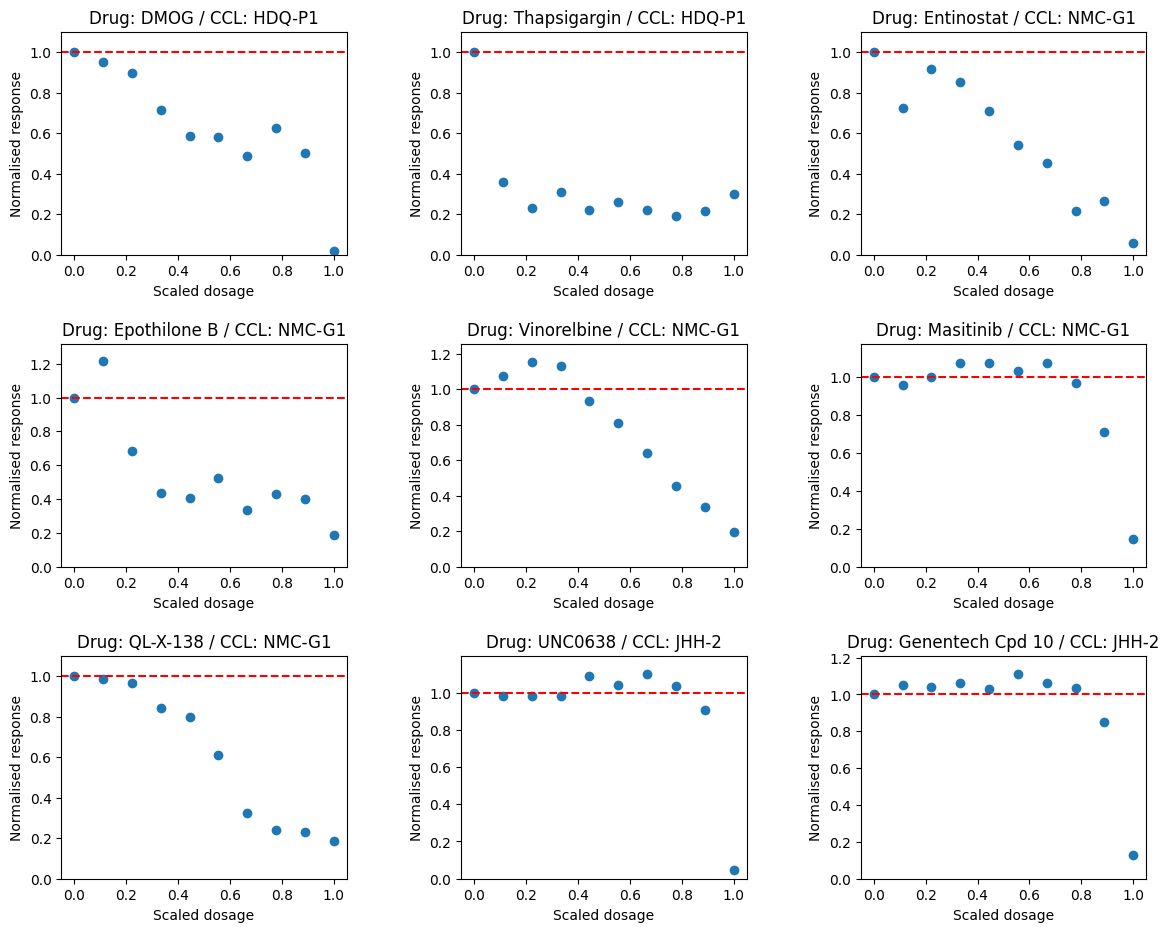

In [51]:
df = not_bad_02_2[not_bad_02_2["low_response_02"]==1]
show_response_curves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9],
                  drug_dict = drug_names, CCL_dict = CCL_names, upper_limit=1)